<a href="https://colab.research.google.com/github/mahmoudarekat/ChicagoCrime/blob/main/ChicagoCrime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs

# Set wide fig size for plots
plt.rcParams['figure.figsize']=(12,3)



In [3]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None,
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)

    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index,
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();

    return fig, ax



In [4]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d,
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags,
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])



In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics



In [6]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5),
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},
                  annotate_seas=False, m = None,
                 seas_color='black'):

    fig, axes = plt.subplots(nrows=2, figsize=figsize)


    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)

    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)

    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)




    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)

        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()

    return fig



In [7]:
import glob
import pandas as pd
from google.colab import drive
folder = "/content/drive/MyDrive/DS Coding Dojo/ChicagoCrime/"
crime_files = sorted(glob.glob(folder+"*.csv"))
df = pd.concat([pd.read_csv(f) for f in crime_files])


In [8]:
df['Date']=pd.to_datetime(df['Date'])

In [9]:
df=df.set_index('Date')

In [10]:
df

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,Count
Date,,,,,,,,,,,,
2001-01-01 01:00:00,1326041.0,BATTERY,SIMPLE,RESIDENCE,False,False,1624.0,16.0,NaN,41.957850,-87.749185,NaN
2001-01-01 13:00:00,1319931.0,BATTERY,SIMPLE,RESIDENCE,False,True,825.0,8.0,NaN,41.783892,-87.684841,NaN
2001-01-01 13:00:00,1324743.0,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313.0,3.0,NaN,41.780412,-87.611970,NaN
2001-01-01 01:00:00,1310717.0,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424.0,24.0,NaN,42.012391,-87.678032,NaN
2001-01-01 01:00:00,1318099.0,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214.0,2.0,NaN,41.819538,-87.620020,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 00:00:00,NaN,WEAPONS VIOLATION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5456.0
2019-12-31 00:00:00,NaN,WEAPONS VIOLATION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6339.0
2020-12-31 00:00:00,NaN,WEAPONS VIOLATION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8432.0


In [11]:
df['Primary Type'].unique()
df['Primary Type']=df['Primary Type'].replace('NON - CRIMINAL','NON-CRIMINAL')
df['Primary Type']=df['Primary Type'].replace('NON-CRIMINAL (SUBJECT SPECIFIED)','NON-CRIMINAL')
df['Primary Type']=df['Primary Type'].replace('OTHER NARCOTIC VIOLATION','NARCOTICS')
df['Primary Type']=df['Primary Type'].replace('CRIM SEXUAL ASSAULT','CRIMINAL SEXUAL ASSAULT')



In [12]:
df['Primary Type'].unique()


array(['BATTERY', 'GAMBLING', 'CRIMINAL DAMAGE',
       'OFFENSE INVOLVING CHILDREN', 'THEFT', 'ASSAULT', 'NARCOTICS',
       'CRIMINAL SEXUAL ASSAULT', 'DECEPTIVE PRACTICE',
       'WEAPONS VIOLATION', 'OTHER OFFENSE', 'MOTOR VEHICLE THEFT',
       'SEX OFFENSE', 'BURGLARY', 'PUBLIC PEACE VIOLATION',
       'LIQUOR LAW VIOLATION', 'ROBBERY', 'CRIMINAL TRESPASS',
       'INTERFERENCE WITH PUBLIC OFFICER', 'HOMICIDE', 'KIDNAPPING',
       'PROSTITUTION', 'STALKING', 'INTIMIDATION', 'ARSON', 'RITUALISM',
       'DOMESTIC VIOLENCE', 'OBSCENITY', 'PUBLIC INDECENCY',
       'CONCEALED CARRY LICENSE VIOLATION', 'NON-CRIMINAL',
       'HUMAN TRAFFICKING'], dtype=object)

In [13]:
df.duplicated().sum()

84

In [14]:
df=df.drop_duplicates(keep='first')

###Part I

In [15]:
df2022=df.loc['2022']

<Axes: >

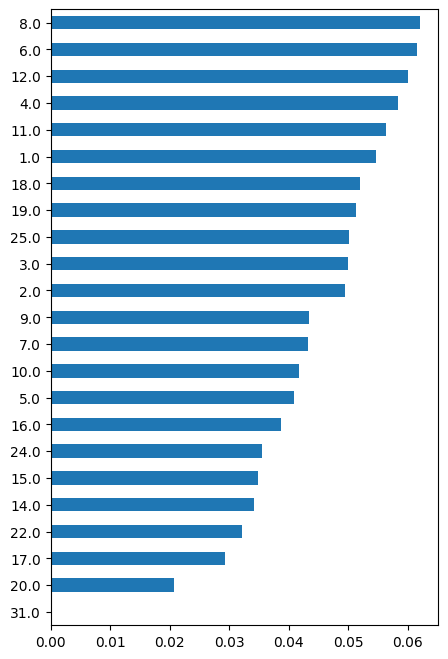

In [16]:
crime_counts = df2022['District'].value_counts(normalize=True)
crime_counts.sort_values().plot(kind='barh',figsize=(5,8))

District number 8 is the district with the most crimes whilast district 20 is the least.

In [17]:
ts=df.groupby('Primary Type').resample('Y').count()

In [18]:
ts.columns

Index(['ID', 'Primary Type', 'Description', 'Location Description', 'Arrest',
       'Domestic', 'Beat', 'District', 'Ward', 'Latitude', 'Longitude',
       'Count'],
      dtype='object')

In [19]:
ts=ts['ID']

In [20]:
ts=ts.to_frame()

In [21]:
df['Primary Type'].unique()

array(['BATTERY', 'GAMBLING', 'CRIMINAL DAMAGE',
       'OFFENSE INVOLVING CHILDREN', 'THEFT', 'ASSAULT', 'NARCOTICS',
       'CRIMINAL SEXUAL ASSAULT', 'DECEPTIVE PRACTICE',
       'WEAPONS VIOLATION', 'OTHER OFFENSE', 'MOTOR VEHICLE THEFT',
       'SEX OFFENSE', 'BURGLARY', 'PUBLIC PEACE VIOLATION',
       'LIQUOR LAW VIOLATION', 'ROBBERY', 'CRIMINAL TRESPASS',
       'INTERFERENCE WITH PUBLIC OFFICER', 'HOMICIDE', 'KIDNAPPING',
       'PROSTITUTION', 'STALKING', 'INTIMIDATION', 'ARSON', 'RITUALISM',
       'DOMESTIC VIOLENCE', 'OBSCENITY', 'PUBLIC INDECENCY',
       'CONCEALED CARRY LICENSE VIOLATION', 'NON-CRIMINAL',
       'HUMAN TRAFFICKING'], dtype=object)

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


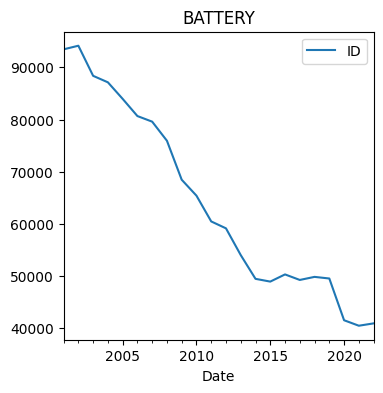

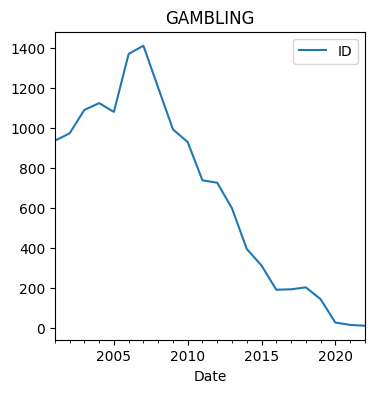

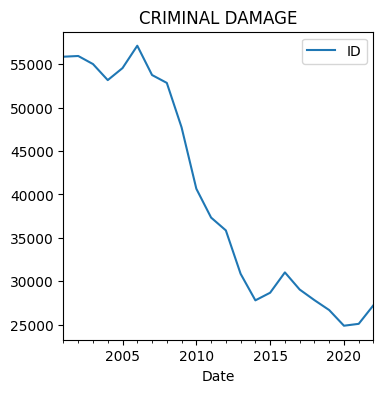

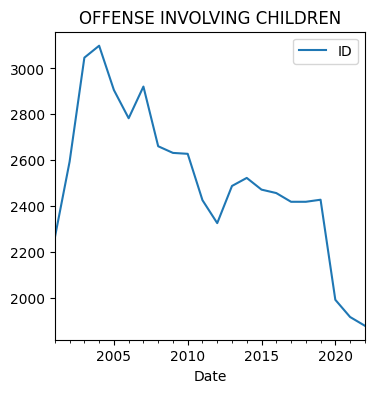

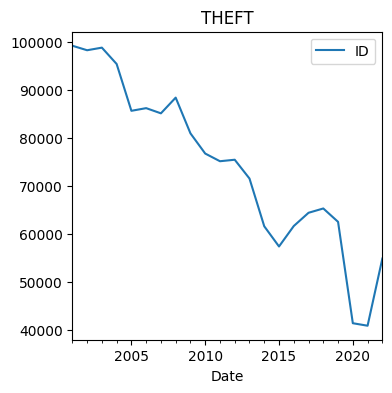

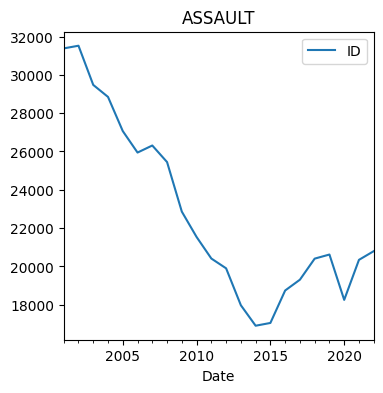

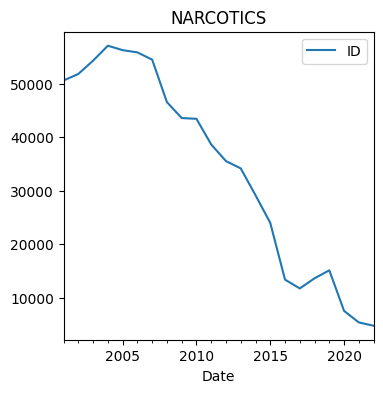

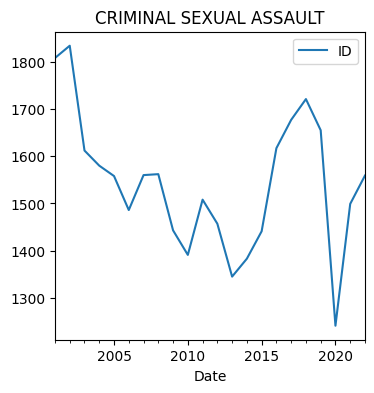

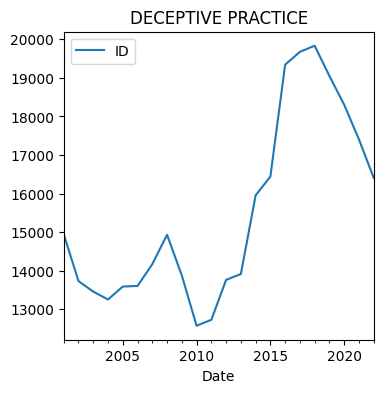

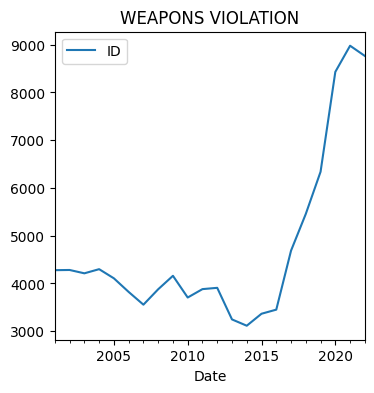

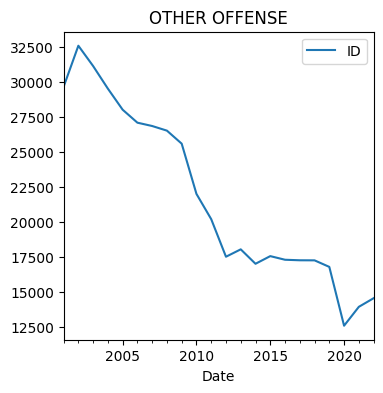

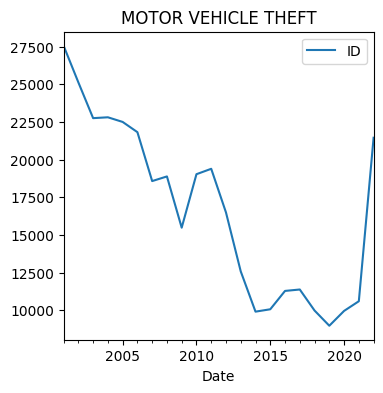

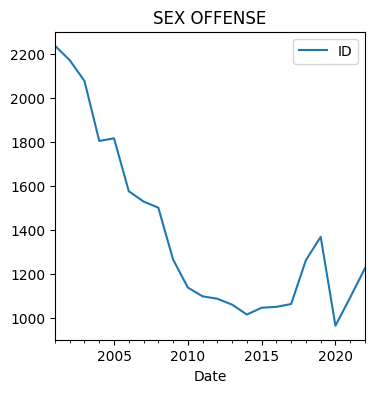

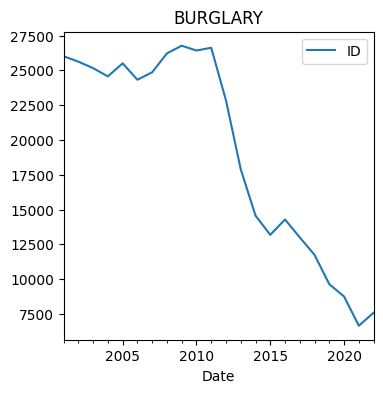

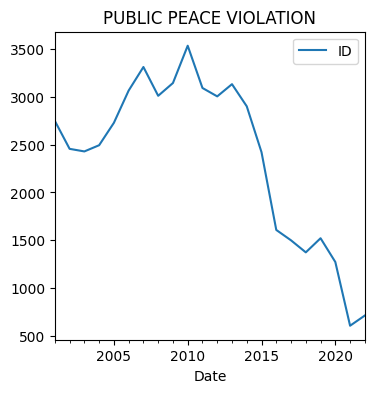

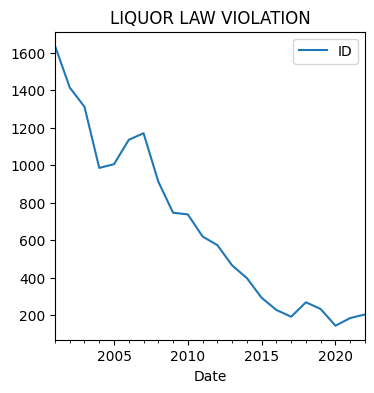

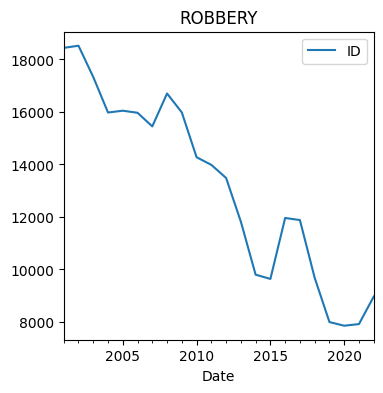

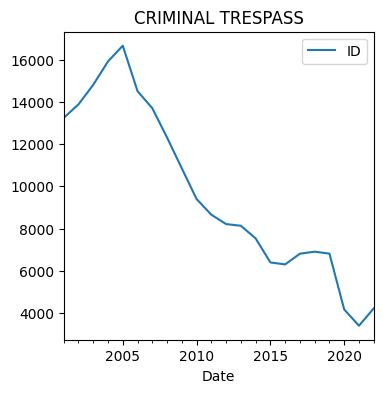

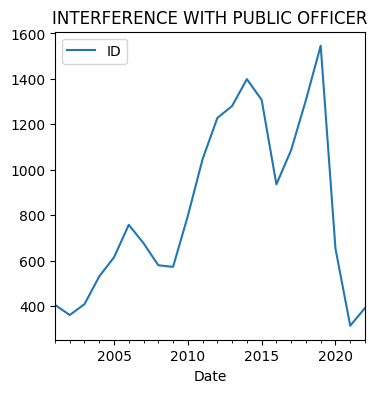

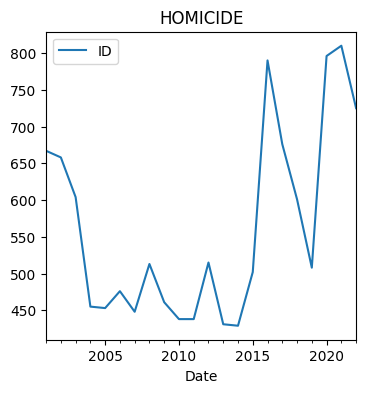

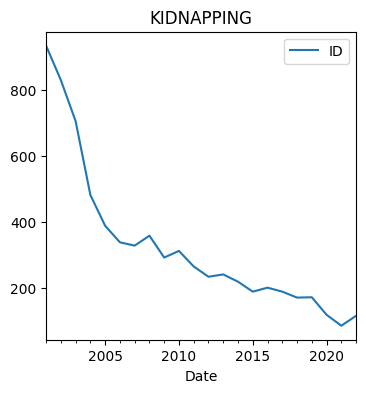

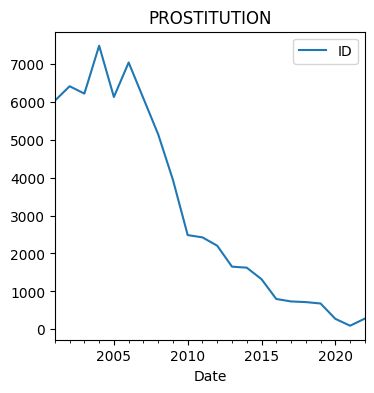

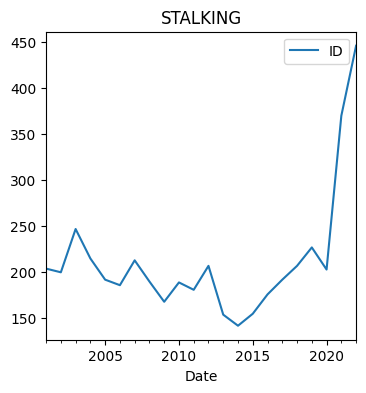

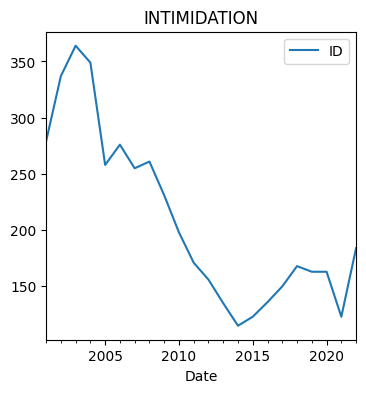

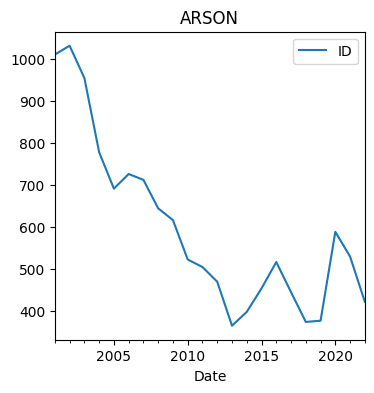

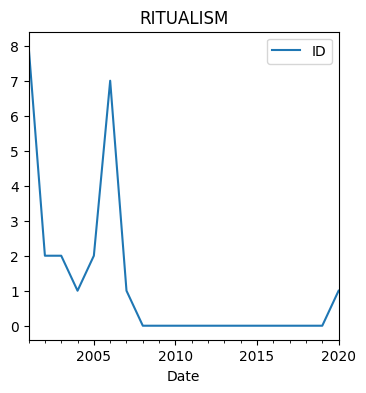

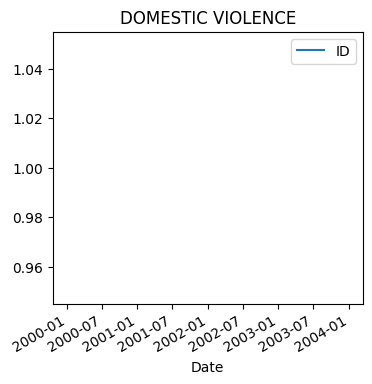

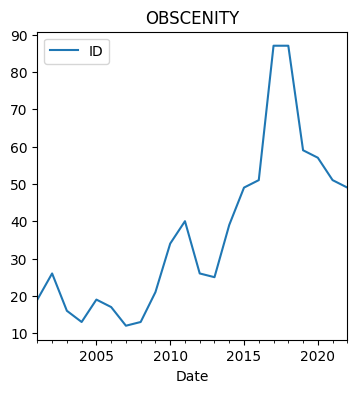

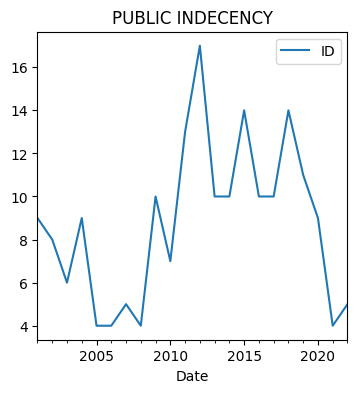

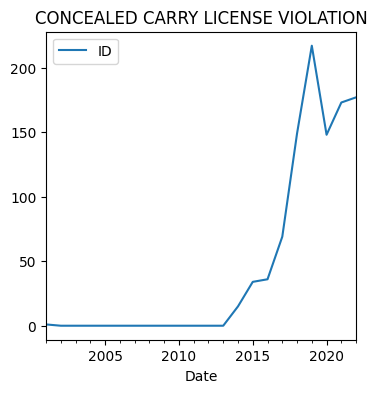

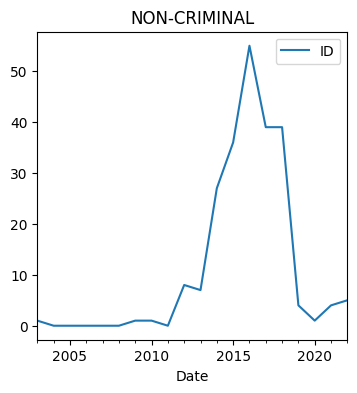

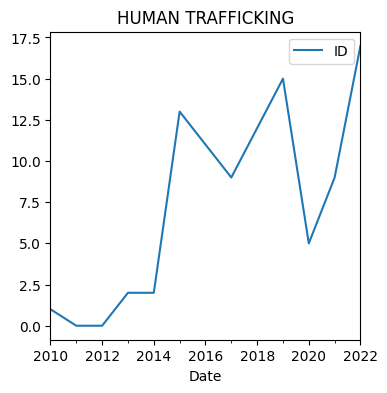

In [22]:
for x in df['Primary Type'].unique():

   ts.loc[x].plot(figsize=(4,4),title=x)


<Axes: title={'center': 'Total Crimes'}, xlabel='Date'>

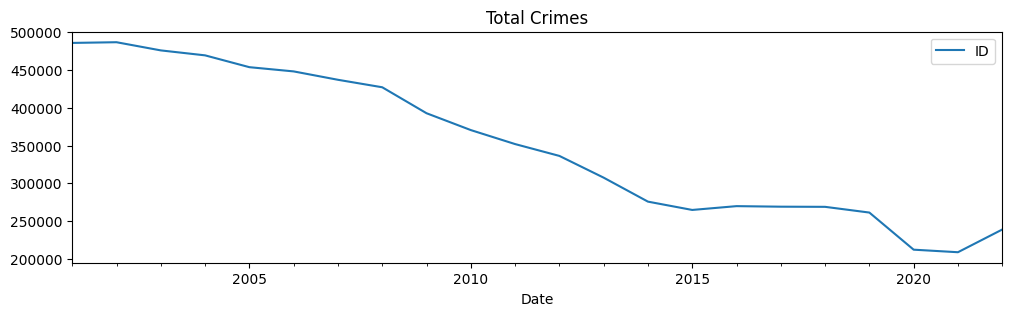

In [23]:
ts.groupby('Date').sum().plot(title='Total Crimes')

Topic 2) Crimes Across the Years:
Is the total number of crimes increasing or decreasing across the years?

The total number of crimes are decreasing.

Are there any individual crimes that are doing the opposite (e.g., decreasing when overall crime is increasing or vice-versa)?


###Part II

For this phase of the project, you will be helping Chicago law enforcement allocate resources for the next 6 months.

You will compare the crime count forecast for 2 of the options below:

Theft
Battery
Narcotics
Assault
Total Crime (sum of all crime types).

I will Choose Narcotics & Total Crime

####Total Crime Analysis

In [24]:
ts_total=df.resample('M').size().to_frame()

In [25]:
ts_total= ts_total.rename(columns={'0' : 'Count'})


In [26]:
ts_total.isna().sum()

0    0
dtype: int64

<Axes: xlabel='Date'>

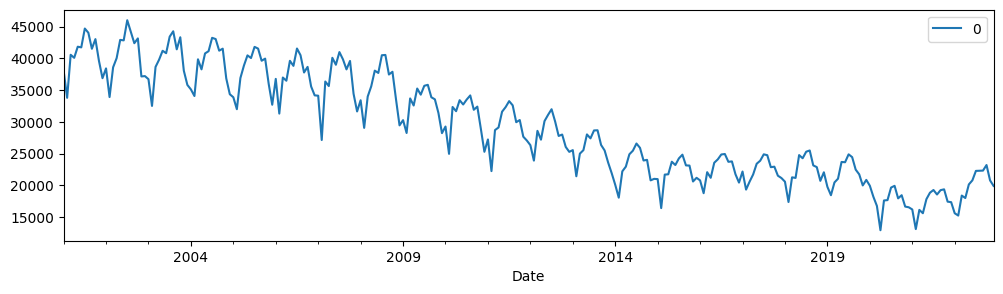

In [27]:
ts_total.plot()

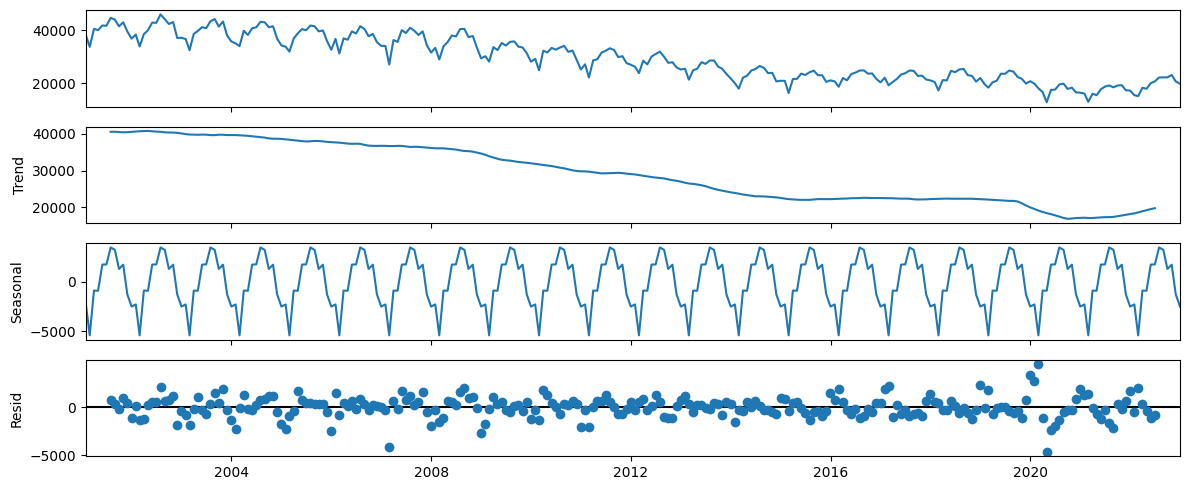

In [28]:
# Apply seasonal decomposition
decomp = tsa.seasonal_decompose(ts_total)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()



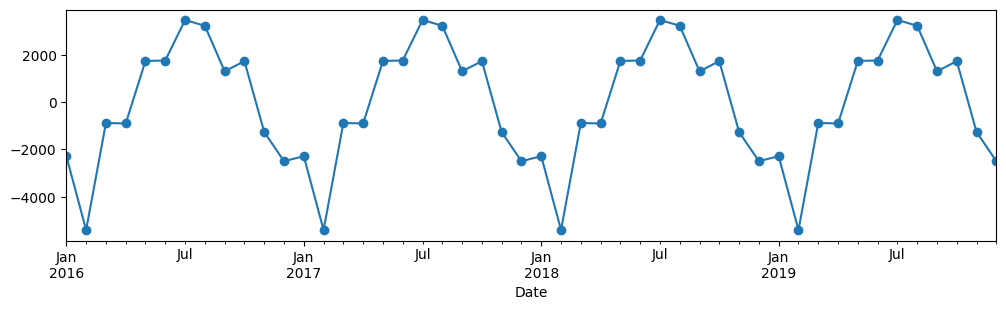

In [29]:
# Narrow down the date range of the plot
seasonal = decomp.seasonal
ax = seasonal.loc['2016': '2019'].plot(marker = 'o')



In [30]:
# Check for stationarity
get_adfuller_results(ts_total)



,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.324998,15,248,0.617659,0.05,False


In [31]:
# determine d
d = ndiffs(ts_total)
print (f'd = {d}')
# determine D
D = nsdiffs(ts_total, m = 12)
print (f'D = {D}')



d = 1
D = 0


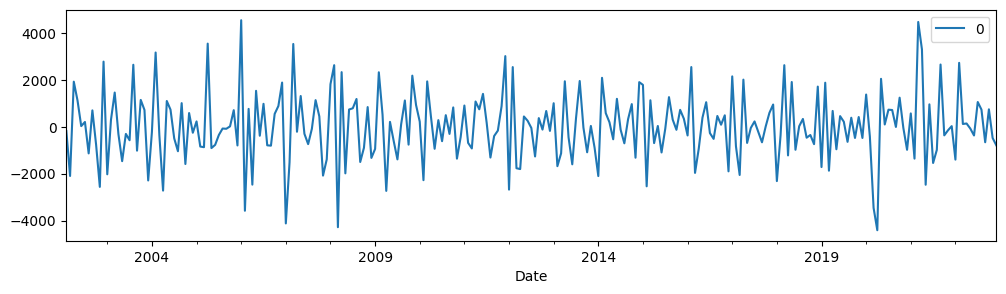

In [32]:
# apply both differencings
ts_total_diff = ts_total.diff().diff(12).dropna()
ts_total_diff.plot();



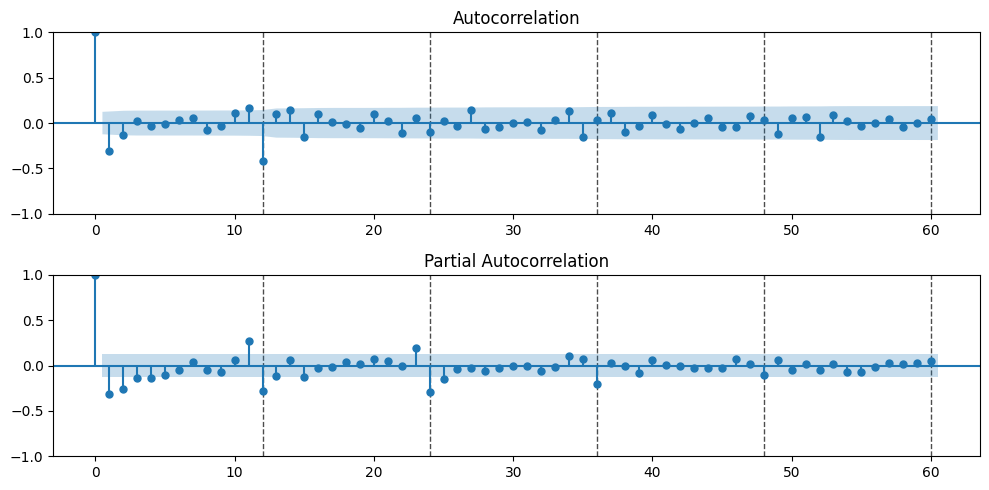

In [33]:
# now look at the acf/pacf of the stationary data
plot_acf_pacf(ts_total_diff, annotate_seas = True, m = 12, nlags = 60);



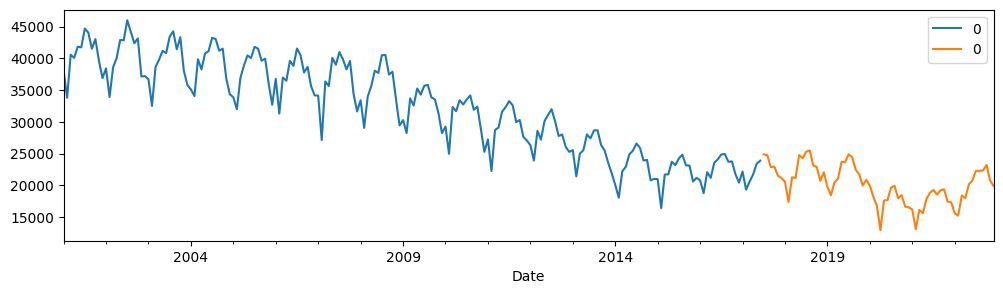

In [34]:
# tts
train, test = train_test_split(ts_total, test_size=.25)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();



In [35]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                0   No. Observations:                  198
Model:             ARIMA(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1740.822
Date:                          Thu, 07 Dec 2023   AIC                           3491.644
Time:                                  17:07:16   BIC                           3508.060
Sample:                              01-31-2001   HQIC                          3498.289
                                   - 06-30-2017                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4193      0.136     -3.092      0.002      -0.685      -0.153
ma.L1          0.2744      0.167      1.646      0.100      -0.052       0.601
ar.S.L12       0.9357      0.018     52.687      0.000       0.901       0.971
ma.S.L12      -0.7663      0.035    -21.709      0.000      -0.835      -0.697
sigma2      2.408e+06   2.53e-08   9.53e+13      0.000    2.41e+06    2.41e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):                87.55
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                            -0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.98e+29. Standard errors may be unstable.
"""

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 1,725.644
- MSE = 5,226,654.531
- RMSE = 2,286.188
- R^2 = 0.408
- MAPE = 9.66%


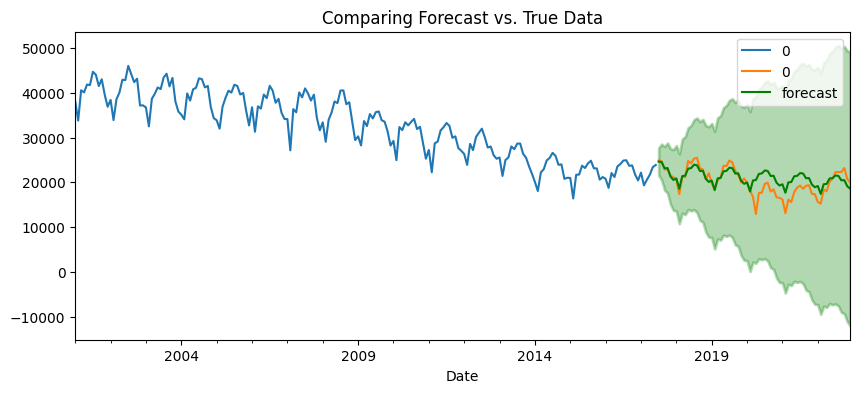

In [36]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])



In [37]:
import pmdarima as pm

# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,
    m=12,
    trace=True
)



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=3523.149, Time=3.53 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3674.605, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3548.507, Time=0.55 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3591.897, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3672.750, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=3588.842, Time=0.49 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=1.37 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=3523.806, Time=3.80 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=3.35 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=3631.817, Time=0.19 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=3554.677, Time=5.64 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=3538.147, Time=4.51 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=3550.640, Time=3.64 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=3530.475, Time=1.20 sec
 ARIMA(2,1,1)(1,0,1)[12] inte

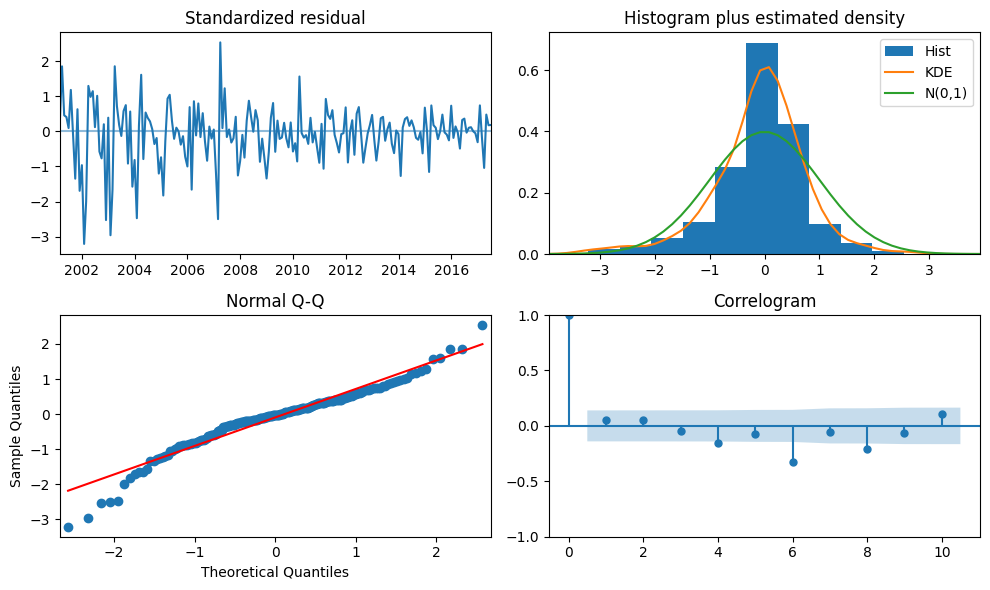

In [38]:
# Obtain diagnostic plots
fig = auto_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 1,742.921
- MSE = 5,391,375.022
- RMSE = 2,321.933
- R^2 = 0.389
- MAPE = 9.79%


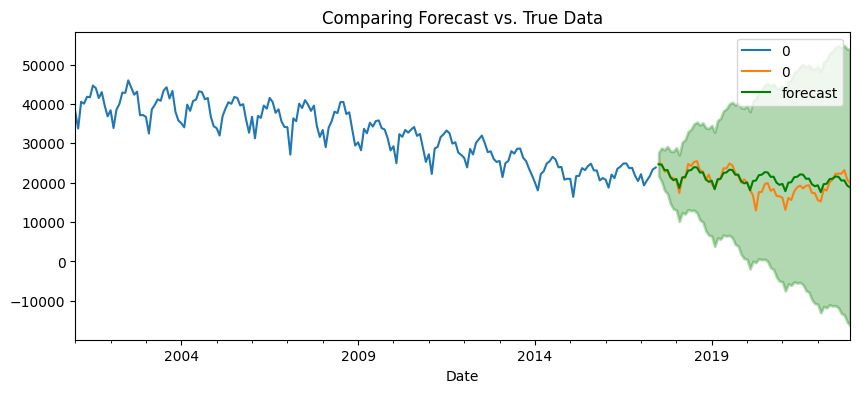

In [39]:
# Use auto_arima parameters to fit an ARIMA
auto_model = tsa.ARIMA(
    train, order=auto_model.order, seasonal_order=auto_model.seasonal_order
).fit()


# Obtain forecast as a dataframe with confidence intervals
forecast_df = auto_model.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])



In [40]:
# These are the parameters of our final model
# Orders for non seasonal components
p =2  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 2  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0 # Seasonal differencing
Q =1  # Seasonal MA
m = 12 # Seasonal period

final_model = tsa.ARIMA(ts_total, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


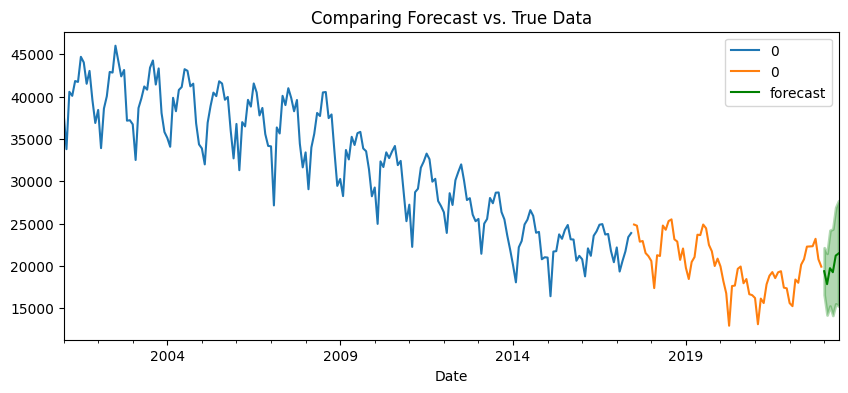

In [41]:
# Obtain future forecasts beyond test data
forecast_df  = final_model.get_forecast(6).summary_frame()
plot_forecast(train,test,forecast_df);



In [42]:
forecast_df.index[0],forecast_df.index[-1]


(Timestamp('2023-01-31 00:00:00', freq='M'),
 Timestamp('2023-06-30 00:00:00', freq='M'))

In [43]:
starting_value = forecast_df['mean'].iloc[0]
starting_value



19363.097743213148

In [44]:
final_value = forecast_df['mean'].iloc[-1]
final_value



21466.520564480754

In [45]:
change = final_value - starting_value
change



2103.422821267606

In [46]:
perc_change = (change / starting_value) * 100
perc_change



10.863049131716878

####Analyzing Narcotics

In [47]:
ts_narc=df.groupby('Primary Type').resample('M').size().loc['NARCOTICS'].to_frame()

In [48]:
ts_narc

,0
Date,
2001-01-31,4715
2001-02-28,4369
2001-03-31,4862
2001-04-30,4044
2001-05-31,4040
...,...
2022-08-31,421
2022-09-30,381
2022-10-31,358


In [49]:
ts_narc= ts_narc.rename(columns={'0     ' : 'Count'})
ts_narc

,0
Date,
2001-01-31,4715
2001-02-28,4369
2001-03-31,4862
2001-04-30,4044
2001-05-31,4040
...,...
2022-08-31,421
2022-09-30,381
2022-10-31,358


<Axes: xlabel='Date'>

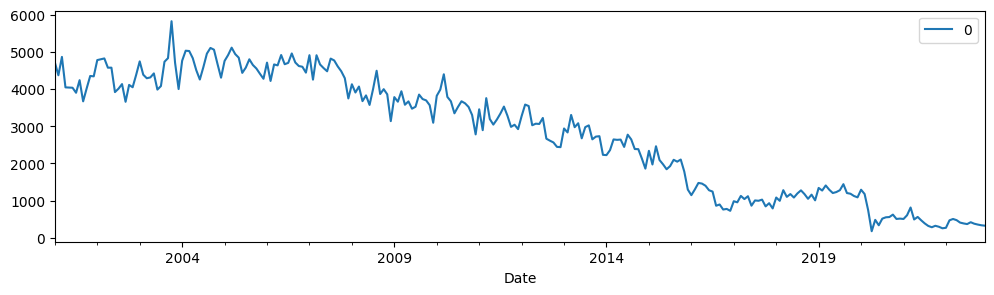

In [50]:
ts_narc.plot()

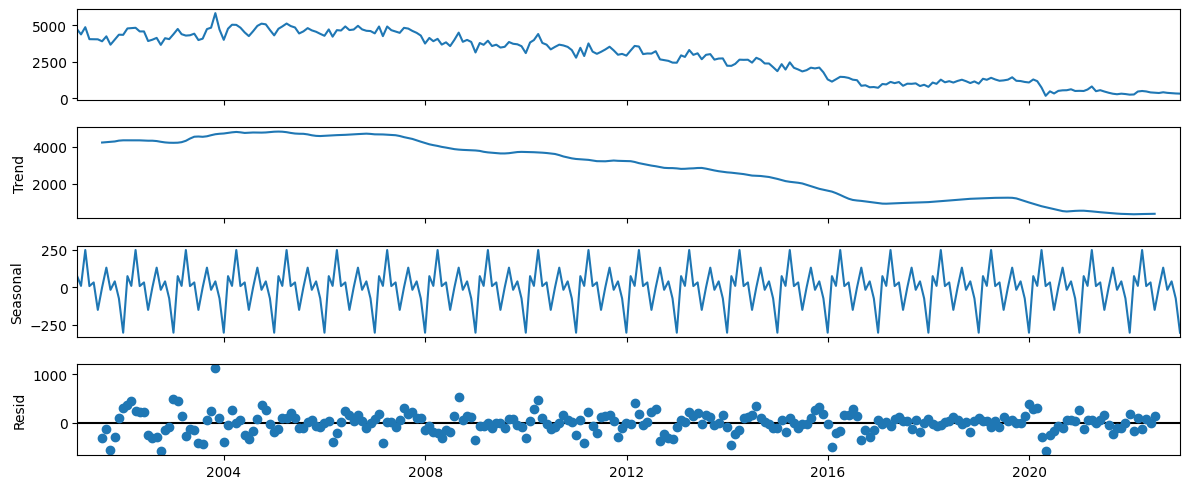

In [51]:
# Apply seasonal decomposition
decomp = tsa.seasonal_decompose(ts_narc)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()



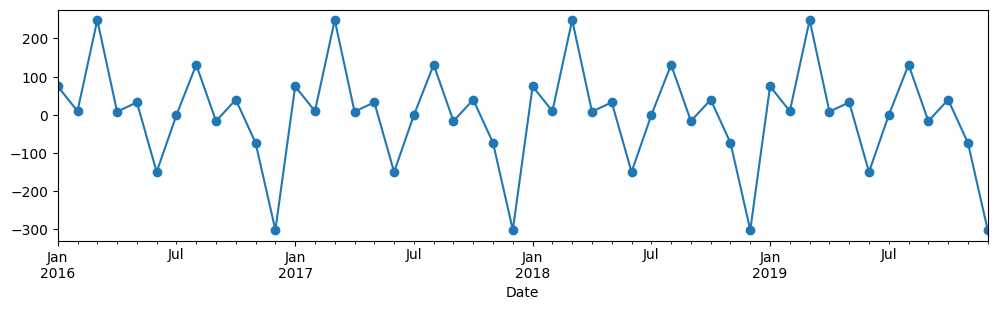

In [52]:
# Narrow down the date range of the plot
seasonal = decomp.seasonal
ax = seasonal.loc['2016': '2019'].plot(marker = 'o')



In [53]:
# Check for stationarity
get_adfuller_results(ts_narc)



,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,0.263818,12,251,0.975622,0.05,False


In [54]:
# determine d
d = ndiffs(ts_narc)
print (f'd = {d}')
# determine D
D = nsdiffs(ts_total, m = 12)
print (f'D = {D}')



d = 1
D = 0


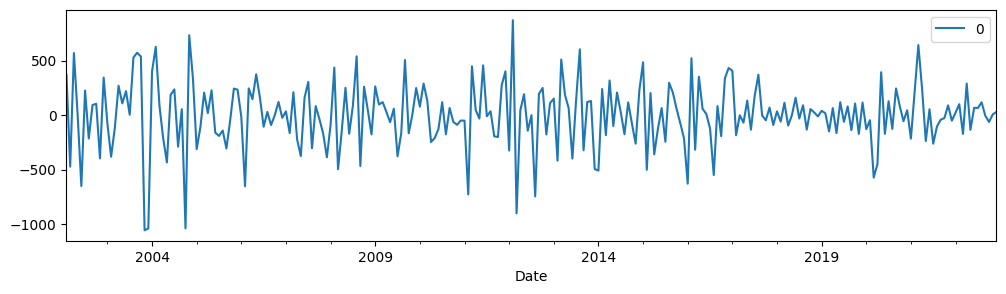

In [55]:
# apply both differencings
ts_narc_diff = ts_narc.diff().diff(12).dropna()
ts_narc_diff.plot();



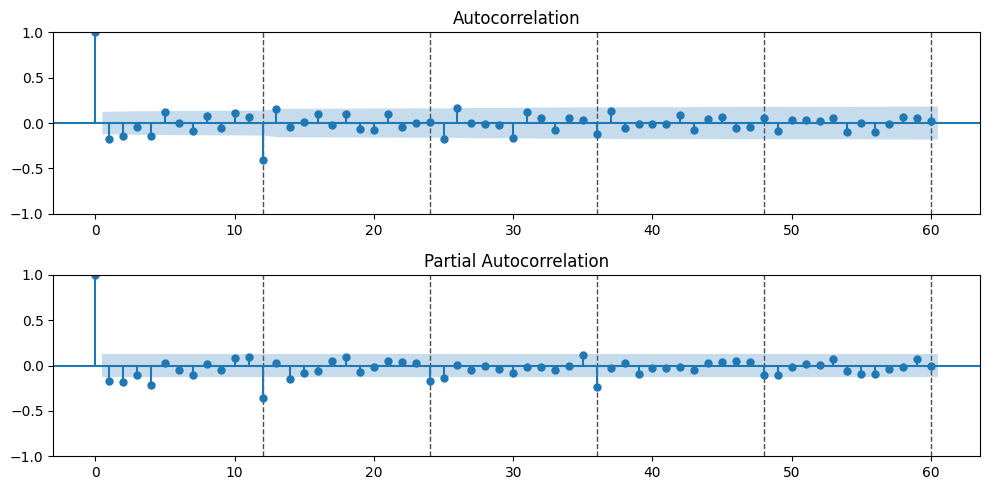

In [56]:
# now look at the acf/pacf of the stationary data
plot_acf_pacf(ts_narc_diff, annotate_seas = True, m = 12, nlags = 60);



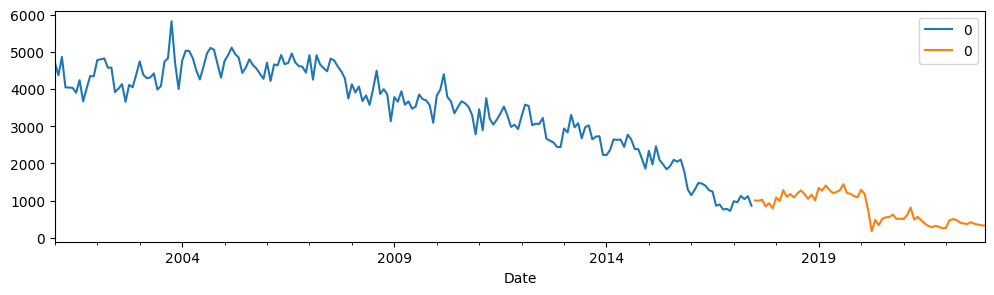

In [57]:
# tts
train, test = train_test_split(ts_narc, test_size=.25)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();



In [58]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                0   No. Observations:                  198
Model:             ARIMA(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1368.456
Date:                          Thu, 07 Dec 2023   AIC                           2746.913
Time:                                  17:08:26   BIC                           2763.329
Sample:                              01-31-2001   HQIC                          2753.558
                                   - 06-30-2017                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5314      0.093      5.707      0.000       0.349       0.714
ma.L1         -0.8475      0.068    -12.457      0.000      -0.981      -0.714
ar.S.L12       0.9466      0.036     26.585      0.000       0.877       1.016
ma.S.L12      -0.7189      0.100     -7.171      0.000      -0.915      -0.522
sigma2      6.121e+04   4899.978     12.492      0.000    5.16e+04    7.08e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                19.44
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -0.03
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 769.739
- MSE = 683,180.546
- RMSE = 826.547
- R^2 = -3.736
- MAPE = 131.78%


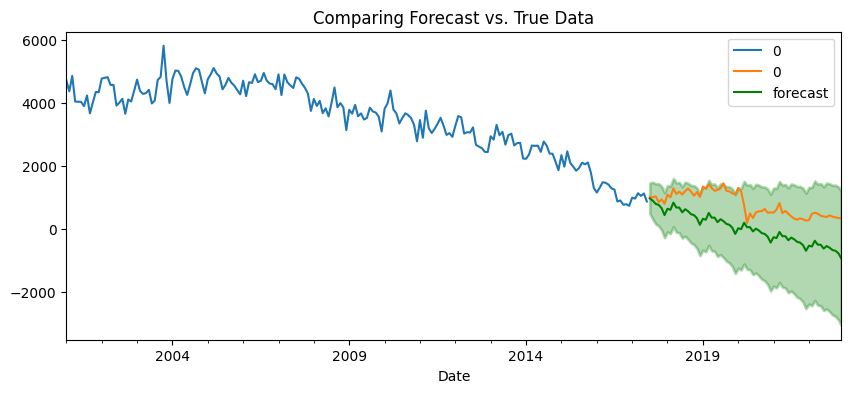

In [59]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])



In [60]:
import pmdarima as pm

# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,
    m=12,
    trace=True
)



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.66 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2851.621, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2784.254, Time=0.30 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2792.957, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2850.298, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2831.484, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2778.657, Time=2.55 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=4.65 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2765.234, Time=1.39 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2799.930, Time=0.29 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=2.51 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2788.942, Time=0.84 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.03 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2770.219, Time=0.64 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : 

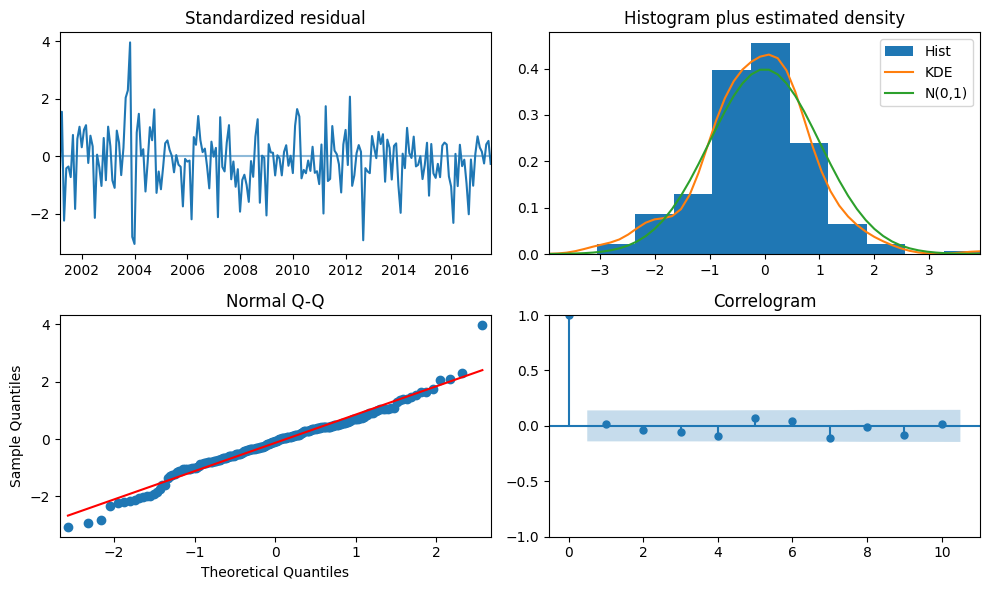

In [61]:
# Obtain diagnostic plots
fig = auto_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 769.739
- MSE = 683,180.546
- RMSE = 826.547
- R^2 = -3.736
- MAPE = 131.78%


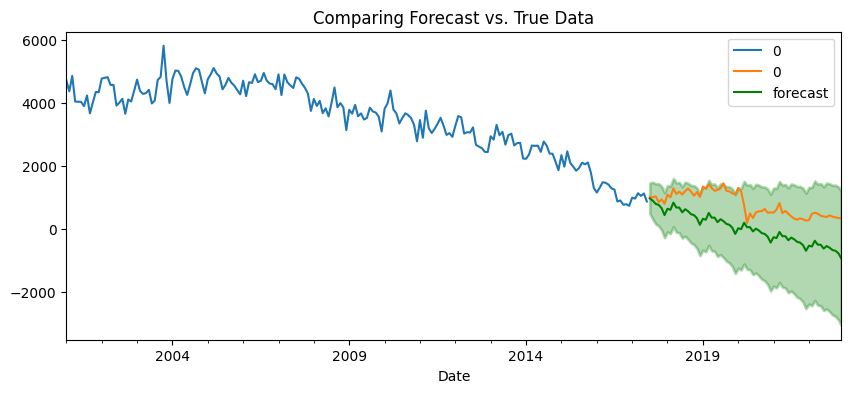

In [62]:
# Use auto_arima parameters to fit an ARIMA
auto_model = tsa.ARIMA(
    train, order=auto_model.order, seasonal_order=auto_model.seasonal_order
).fit()


# Obtain forecast as a dataframe with confidence intervals
forecast_df = auto_model.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])



In [71]:
# These are the parameters of our final model
# Orders for non seasonal components
p =1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1 # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0 # Seasonal differencing
Q =1  # Seasonal MA
m = 12 # Seasonal period

final_model_narc = tsa.ARIMA(ts_narc, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


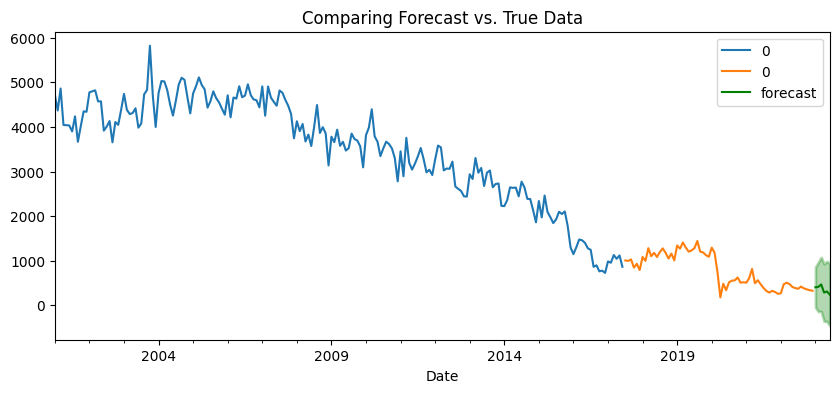

In [72]:
# Obtain future forecasts beyond test data
forecast_df_narc  = final_model_narc.get_forecast(6).summary_frame()
plot_forecast(train,test,forecast_df_narc);



In [65]:
forecast_df.index[0],forecast_df.index[-1]


(Timestamp('2023-01-31 00:00:00', freq='M'),
 Timestamp('2023-06-30 00:00:00', freq='M'))

In [66]:
starting_value = forecast_df['mean'].iloc[0]
starting_value



19363.097743213148

In [67]:
final_value = forecast_df['mean'].iloc[-1]
final_value



21466.520564480754

In [68]:
change = final_value - starting_value
change



2103.422821267606

In [69]:
perc_change = (change / starting_value) * 100
perc_change



10.863049131716878